In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [5]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [6]:
n_lags = 3  # Start with 3 lags, adjust based on your data's characteristics

# Create lagged features
for lag in range(1, n_lags + 1):
    df[f'Biomass_lag_{lag}'] = df['Biomass'].shift(lag)

# Drop rows with NaN values (which are created by shifting)
df.dropna(inplace=True)

# Define features (X) and target (y)
X = df[[f'Biomass_lag_{lag}' for lag in range(1, n_lags + 1)]].values
y = df['Biomass'].values



In [7]:
# Define and configure the SVR model
svr = SVR()
# Use GridSearchCV to optimize the model parameters
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10], 'gamma': ['scale', 'auto']}
svr_optimized = GridSearchCV(svr, parameters, cv=5)

In [8]:
# Train the optimized model on the entire dataset
svr_optimized.fit(X, y)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'rbf')})

In [9]:
# Make predictions using the model
y_pred = svr_optimized.predict(X)

# Calculate the evaluation metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mse = mean_squared_error(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

# Print the evaluation metrics
print(f"R-squared: {r2}\nMAE: {mae}\nRMSE: {rmse}\nMSE: {mse}\nMAPE: {mape}")

R-squared: 0.5779618812889158
MAE: 24.903502115449392
RMSE: 32.48165193986675
MSE: 1055.0577127426493
MAPE: 9.500285409103794


In [10]:
# Assuming y and y_pred are available
# Ensure the index of your DataFrame (df) matches the length of y and y_pred

# Convert y and y_pred to pandas series with proper indexing
actual_series = pd.Series(y, index=df.index[-len(y):])
predicted_series = pd.Series(y_pred, index=df.index[-len(y_pred):])

# Calculate residuals (actual - predicted)
residuals = actual_series - predicted_series

# Create a new DataFrame
results_df = pd.DataFrame({
    'Actual': actual_series,
    'Predicted': predicted_series,
    'Residual': residuals
})
print(results_df.head())

            Actual   Predicted   Residual
Date                                     
2016-04-01  323.28  327.229119  -3.949119
2016-05-01  334.64  314.364793  20.275207
2016-06-01  348.29  319.415058  28.874942
2016-07-01  313.39  326.590839 -13.200839
2016-08-01  347.74  308.301214  39.438786


In [12]:
# Saving the results to a new CSV file
results_file_path = 'C:/Users/pacha/OneDrive/svr_forecasting_results.csv'  # Replace with your desired file path
results_df.to_csv(results_file_path)

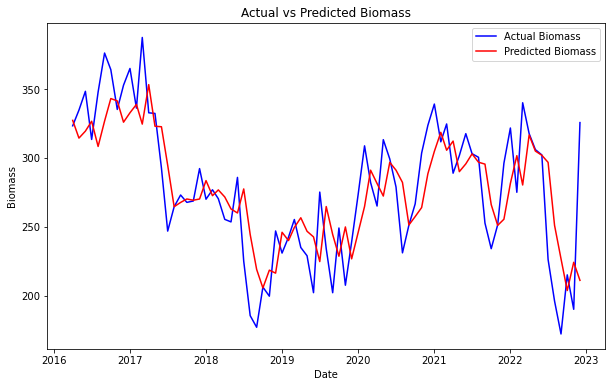

In [13]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y):], y, label='Actual Biomass', color='blue')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Biomass', color='red')
plt.title('Actual vs Predicted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()


In [14]:
# Forecasting the next 30 months
future_dates = pd.date_range(start=df.index[-1], periods=31, freq='M')[1:]
future_predictions = []

current_features = df[[f'Biomass_lag_{lag}' for lag in range(1, n_lags + 1)]].iloc[-1].tolist()

for _ in range(30):
    next_prediction = svr_optimized.predict([current_features])[0]
    future_predictions.append(next_prediction)
    
    # Update the features for the next prediction
    current_features = current_features[1:] + [next_prediction]

future_predictions_series = pd.Series(future_predictions, index=future_dates)


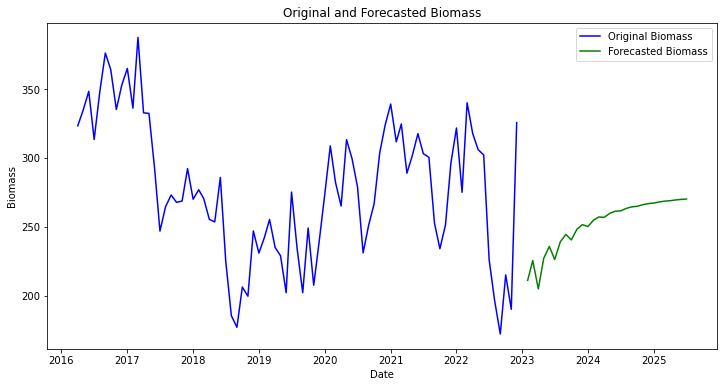

In [15]:
# Plotting the forecasted values alongside the original biomass data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Original Biomass', color='blue')
plt.plot(future_dates, future_predictions_series, label='Forecasted Biomass', color='green')
plt.title('Original and Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()
